# Spectrum Skeleton Generator

This jupyter notebook fits an experimental spectrum with Lorentzian peaks, and outputs the fitted peaks in a JSON format.

## Import Required Packages

In [1]:
import dataphile
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from dataphile.statistics.regression.modeling import Parameter, Model, CompositeModel, AutoGUI
from dataphile.statistics.distributions import gaussian1D, polynomial1D
import json

## Define Helper Functions

In [2]:
def Lorentzian1D(x: np.ndarray, amplitude, center, stdev) -> np.ndarray:
    """A one dimensional Lorentzian distribution.
       = amplitude * exp(-0.5 (x - center)**2 / stdev**2)
       = amplitude / (1 + ((x - center)/(stdev/2))**2)
    """
    return amplitude / (1 + ((x - center)/(stdev/2))**2)


In [3]:
def get_model_params_nicely(model):
    """
    Get the model paramters in a way that can be used to make spectrum skeletons
    """
    output_list = []
    sugar_list = []

    for p in model.parameters:

        if p.label == 'amplitude':
            tmp_dict = {'amplitude': p.value}
        if p.label == 'center':
            tmp_dict['wavenumber'] = p.value
        if p.label == 'width':
            tmp_dict['width'] = p.value
            sugar_list.append(tmp_dict)

    new_sugar_list = []
    for dicts in sugar_list:
        new_sugar_list.append({'wavenumber': round(dicts['wavenumber'],0),
                                'amplitude': round(dicts['amplitude'],3),
                                'width': round(dicts['width'],2)})
    for item in new_sugar_list:
        output_list.append(item)
    
    return output_list 

## Load in experimental spectra

In [4]:
filelist = glob.glob('data/*.csv')
print(filelist)
df_list = []
df_name = []
data_dict = {}
for file in filelist:
    df_list.append(pd.read_csv(file))
    df_name.append(os.path.basename(file).split('.')[0])

    data = df_list[-1].to_numpy()
    xdata = data[:, 0] 
    ydata = data[:, 1] - data[6,1] #data[6,1] is a quick baseline hack
    data_dict[df_name[-1]] = (xdata, ydata)

['data/fructose.csv', 'data/glucose.csv', 'data/sucrose.csv']


In [5]:
from matplotlib import pyplot as plot
plt.style.use('seaborn-notebook')

## Plot Spectra

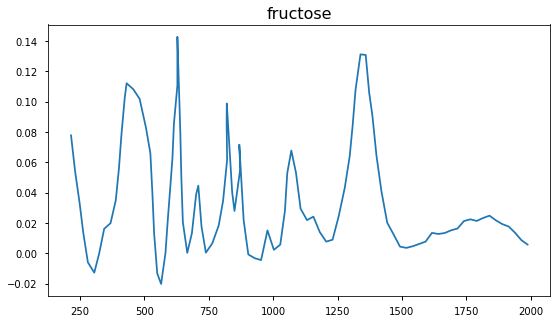

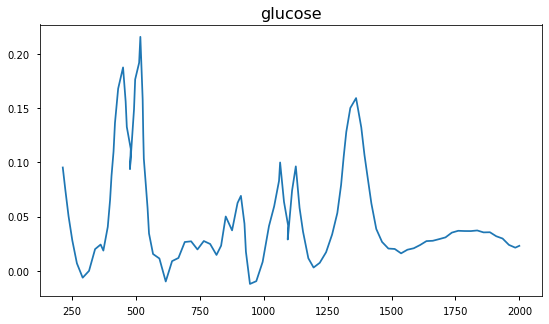

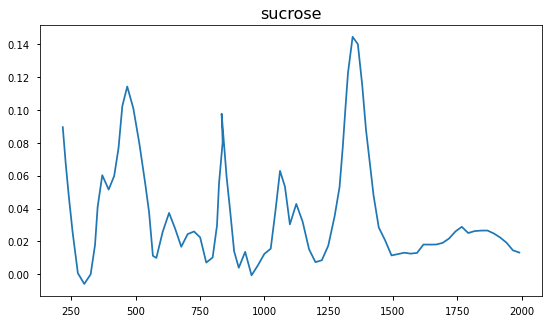

In [6]:
for key, value in data_dict.items():
    xdata, ydata = value 
    figure = plot.figure(key, figsize=(9, 5))
    plt.plot(xdata, ydata)
    plt.title(key, fontsize=16)


## Guess Peak Locations

In [24]:
peak_dict = {'glucose':[450, 523, 759, 853, 912, 1063, 1122, 1358, 1784],
             'fructose': [425, 629, 822, 872, 1079, 1353, 1784],
              'sucrose': [472, 844, 1129, 1356]}

## Fit peaks and store in Dictionary 

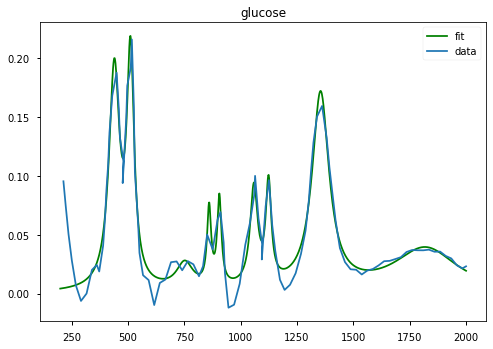

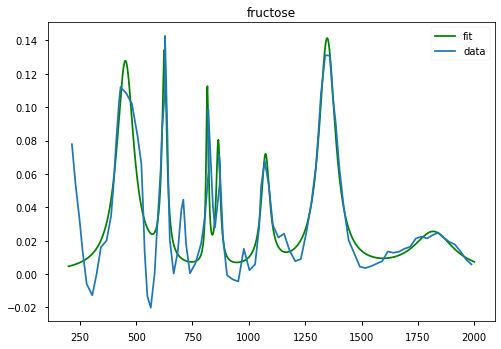

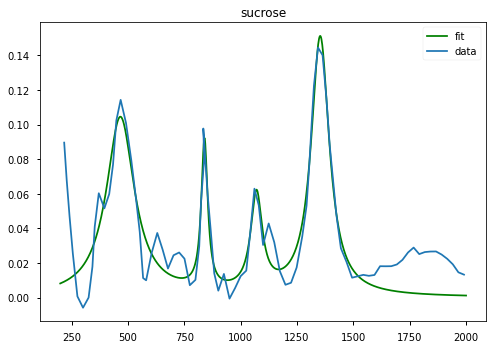

In [25]:
peak_skeleton_dict = {}
for key, val in peak_dict.items():
    model_list = []
    for point in val:
        tmp_model = Model(Lorentzian1D,  # guassian1D works better in this case. Ch 
              Parameter(value=0.1, bounds=(0, 1),  label='amplitude'),
              Parameter(value=point, bounds=(200, 2000), label='center'),
              Parameter(value=50,  bounds=(0, 100),    label='width'),
              label='feature_1')

        model_list.append(tmp_model)
    model = CompositeModel(*model_list,
    label=key)
    xdata, ydata = data_dict[key]

    model.fit(xdata, ydata)
    xsample = np.linspace(200, 2000, 1000)
    plt.figure(key)
    model_graph, = plt.plot(xsample, model(xsample), color='green', label='fit')
    plt.plot(xdata, ydata, label='data')
    plt.legend()
    plt.title(key)
    peak_skeleton_dict[key] = get_model_params_nicely(model)

In [26]:
peak_skeleton_dict

{'glucose': [{'wavenumber': 440.0, 'amplitude': 0.185, 'width': 56.28},
  {'wavenumber': 512.0, 'amplitude': 0.192, 'width': 38.64},
  {'wavenumber': 752.0, 'amplitude': 0.022, 'width': 90.09},
  {'wavenumber': 860.0, 'amplitude': 0.065, 'width': 21.21},
  {'wavenumber': 906.0, 'amplitude': 0.074, 'width': 22.03},
  {'wavenumber': 1059.0, 'amplitude': 0.083, 'width': 40.51},
  {'wavenumber': 1124.0, 'amplitude': 0.084, 'width': 28.74},
  {'wavenumber': 1355.0, 'amplitude': 0.166, 'width': 90.66},
  {'wavenumber': 1820.0, 'amplitude': 0.038, 'width': 349.7}],
 'fructose': [{'wavenumber': 452.0, 'amplitude': 0.127, 'width': 92.35},
  {'wavenumber': 626.0, 'amplitude': 0.125, 'width': 25.16},
  {'wavenumber': 816.0, 'amplitude': 0.105, 'width': 13.13},
  {'wavenumber': 864.0, 'amplitude': 0.075, 'width': 21.68},
  {'wavenumber': 1074.0, 'amplitude': 0.067, 'width': 45.49},
  {'wavenumber': 1347.0, 'amplitude': 0.139, 'width': 88.64},
  {'wavenumber': 1819.0, 'amplitude': 0.024, 'width': 2

## Save dictionary as a JSON

In [29]:
with open('data/sugar_out.json', 'w') as f:
    json.dump(peak_skeleton_dict, f, sort_keys=True, indent=4, separators=(',', ': '))